# Bhavika Prasannakumar - HW4
# Using Detectron2

In [29]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu122


Looking in indexes: https://download.pytorch.org/whl/cu122


## Install Detectron2

In [30]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-emerr0uu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-emerr0uu
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done


In [31]:
import detectron2
print("Detectron2 imported successfully!")


Detectron2 imported successfully!


## Install necessary libraries

In [32]:
import os
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances


## Prepare dataset in COCO format

In [33]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
train_images_path = "/content/drive/MyDrive/HW4-detectron2/train"
train_annotations_path = "/content/drive/MyDrive/HW4-detectron2/train/_annotations.coco.json"

In [35]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Remove existing dataset registration
DatasetCatalog.remove("my_train_dataset")
MetadataCatalog.remove("my_train_dataset")


## Register the dataset with Detectron2


In [36]:
# Register the dataset with Detectron2
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_train_dataset", {}, train_annotations_path, train_images_path)

In [37]:
# Retrieve metadata and dataset information
from detectron2.data import MetadataCatalog, DatasetCatalog
train_metadata = MetadataCatalog.get("my_train_dataset")
train_dataset_dicts = DatasetCatalog.get("my_train_dataset")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [38]:
# Update model configuration output directory
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer

In [39]:
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml -P /content


--2024-09-29 19:21:42--  https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193 [text/plain]
Saving to: ‘/content/faster_rcnn_R_50_FPN_3x.yaml.2’

faster_rcnn_R_50_FP 100%[===================>]     193  --.-KB/s    in 0s      

2024-09-29 19:21:42 (16.0 MB/s) - ‘/content/faster_rcnn_R_50_FPN_3x.yaml.2’ saved [193/193]



In [40]:
# Print the content of the config file to verify its contents
with open("/content/faster_rcnn_R_50_FPN_3x.yaml.1", "r") as f:
    print(f.read())


_BASE_: "../Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
  MASK_ON: False
  RESNETS:
    DEPTH: 50
SOLVER:
  STEPS: (210000, 250000)
  MAX_ITER: 270000



In [42]:
!ls /content

Base-RCNN-FPN.yaml  faster_rcnn_R_50_FPN_3x.yaml    faster_rcnn_R_50_FPN_3x.yaml.2
drive		    faster_rcnn_R_50_FPN_3x.yaml.1  sample_data


In [43]:
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/Base-RCNN-FPN.yaml -P /content


--2024-09-29 19:22:06--  https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/Base-RCNN-FPN.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318 (1.3K) [text/plain]
Saving to: ‘/content/Base-RCNN-FPN.yaml.1’

Base-RCNN-FPN.yaml. 100%[===================>]   1.29K  --.-KB/s    in 0s      

2024-09-29 19:22:06 (114 MB/s) - ‘/content/Base-RCNN-FPN.yaml.1’ saved [1318/1318]



In [46]:
cfg.merge_from_file("/content/faster_rcnn_R_50_FPN_3x.yaml")


## Register the test and validation set

In [47]:
# Register validation dataset
register_coco_instances("my_val_dataset", {}, "/content/drive/MyDrive/HW4-detectron2/valid/_annotations.coco.json", "/content/drive/MyDrive/HW4-detectron2/valid")

# Register test dataset
register_coco_instances("my_test_dataset", {}, "/content/drive/MyDrive/HW4-detectron2/test/_annotations.coco.json", "/content/drive/MyDrive/HW4-detectron2/test")

In [48]:
# Set your dataset
cfg.DATASETS.TRAIN = ("my_train_dataset",)  # Training dataset
cfg.DATASETS.TEST = ("my_val_dataset",)     # Validation dataset for evaluation during training


In [49]:
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"  # Path to pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

In [50]:
# Save outputs to Google Drive
cfg.OUTPUT_DIR = "/content/drive/MyDrive/detectron2_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## Train the model

In [51]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[09/29 19:29:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

R-50.pkl: 102MB [00:08, 12.3MB/s]                            


[09/29 19:29:48 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/29 19:29:48 d2.checkpoint.c2_model_loading]: Following weights matched with submodule model - Total num: 54


proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[09/29 19:29:48 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/29 19:30:09 d2.utils.events]:  eta: 0:12:08  iter: 19  total_loss: 3.521  loss_cls: 2.214  loss_box_reg: 0.3069  loss_rpn_cls: 0.6922  loss_rpn_loc: 0.3168    time: 0.8037  last_time: 0.7225  data_time: 0.6080  last_data_time: 0.5211   lr: 4.9953e-06  max_mem: 1760M
[09/29 19:30:27 d2.utils.events]:  eta: 0:11:30  iter: 39  total_loss: 3.083  loss_cls: 1.804  loss_box_reg: 0.2853  loss_rpn_cls: 0.6828  loss_rpn_loc: 0.2658    time: 0.7640  last_time: 0.5846  data_time: 0.5177  last_data_time: 0.3770   lr: 9.9902e-06  max_mem: 1761M
[09/29 19:30:44 d2.utils.events]:  eta: 0:11:27  iter: 59  total_loss: 2.355  loss_cls: 1.115  loss_box_reg: 0.3367  loss_rpn_cls: 0.6813  loss_rpn_loc: 0.2628    time: 0.7945  last_time: 0.7479  data_time: 0.6480  last_data_time: 0.5412   lr: 1.4985e-05  max_mem: 1761M
[09/29 19:30:58 d2.utils.events]:  eta: 0:11:07  iter: 79  total_loss: 1.776  loss_cls: 0.5384  loss_box_reg: 0.3284  loss_rpn_cls: 0.6777  loss_rpn_loc: 0.2448    time: 0.7747  last_time

## Model Training

The model training process involved training a `GeneralizedRCNN` model with a `ResNet` backbone, using a `Region Proposal Network` (RPN) to generate potential object regions. The dataset used contained 534 training images spanning 7 categories, with the model leveraging data augmentations like resizing and flipping to enhance robustness. Training was conducted over 1000 iterations with a batch size of 2, and the loss function, comprising classification, box regression, and RPN losses, steadily decreased throughout, indicating effective learning and model convergence. The learning rate was adjusted dynamically, and checkpoints were used to store progress. After training, a validation set with 51 images was loaded for evaluation, though additional steps were suggested to properly evaluate model performance. Overall, the process showcased a gradual improvement in the model's ability to detect and classify the object categories in the dataset.

## Model Evaluation Results

In [52]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Load the trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Ensure path is correct
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for evaluation
predictor = DefaultPredictor(cfg)

# Create evaluator for test set
evaluator = COCOEvaluator("my_test_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "my_test_dataset")

# Run inference and print metrics
metrics = inference_on_dataset(predictor.model, val_loader, evaluator)
print(metrics)


[09/29 19:44:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/detectron2_output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

WARNING [09/29 19:44:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [09/29 19:44:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/29 19:44:42 d2.data.datasets.coco]: Loaded 26 images in COCO format from /content/drive/MyDrive/HW4-detectron2/test/_annotations.coco.json
[09/29 19:44:42 d2.data.build]: Distribution of instances among all 7 categories:
|  category  | #instances   |   category   | #instances   |  category  | #instances   |
|:----------:|:-------------|:------------:|:-------------|:----------:|:-------------|
|   aiHub    | 0            |    Hammer    | 6            |   Pliers   | 4            |
|    Rope    | 5            | Screw Driver | 12           |  Tool Box  | 4            |
|   Wrench   | 14           |              |              |            |              |
|   total    | 45          

## Results

The evaluation of the `Detectron2` model on the test dataset demonstrates promising results, achieving an overall AP of 14.0%, with an AP50 of 32.5%, indicating strong performance in terms of correct detections at a lower IoU threshold. The model performs particularly well on larger objects, with consistent recall (AR) reaching up to 26.0% when allowing more detections. Among the categories, "Hammer" and "Rope" are predicted most accurately, achieving APs of 27.6% and 22.3%, respectively, showcasing the model's capability to effectively learn certain object classes. Although some categories like "Screw Driver" and "Wrench" have room for improvement, this evaluation highlights the model's strengths and offers a solid foundation for further fine-tuning to enhance performance across all categories and object sizes.

## Visualize the results

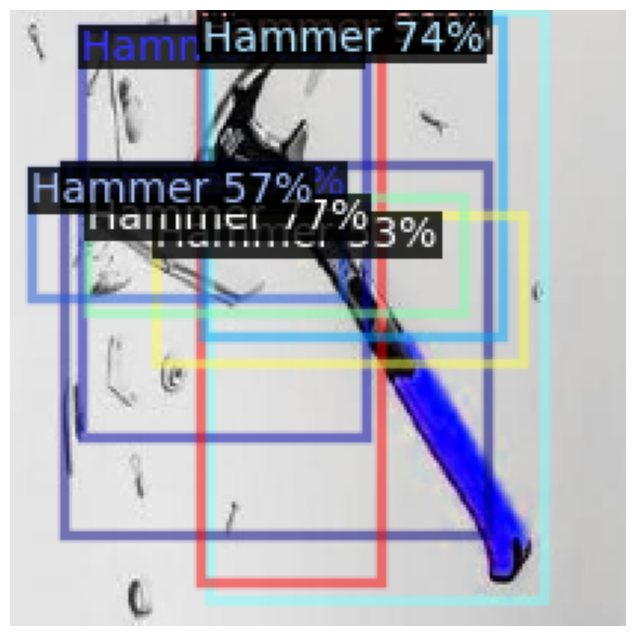

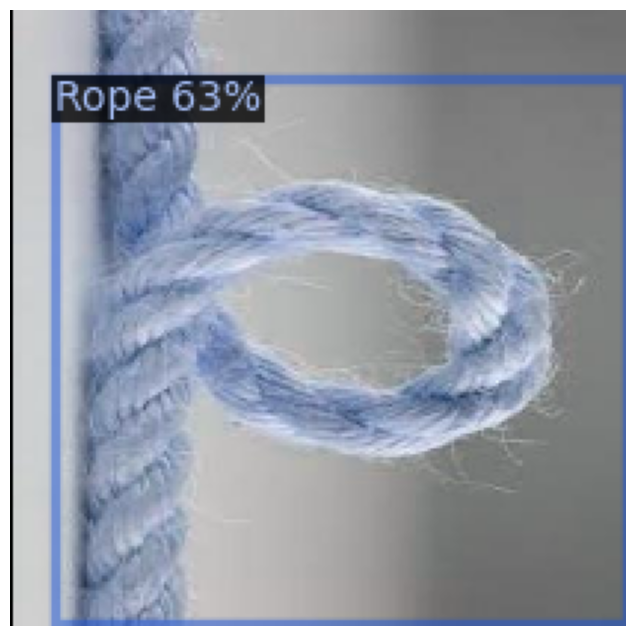

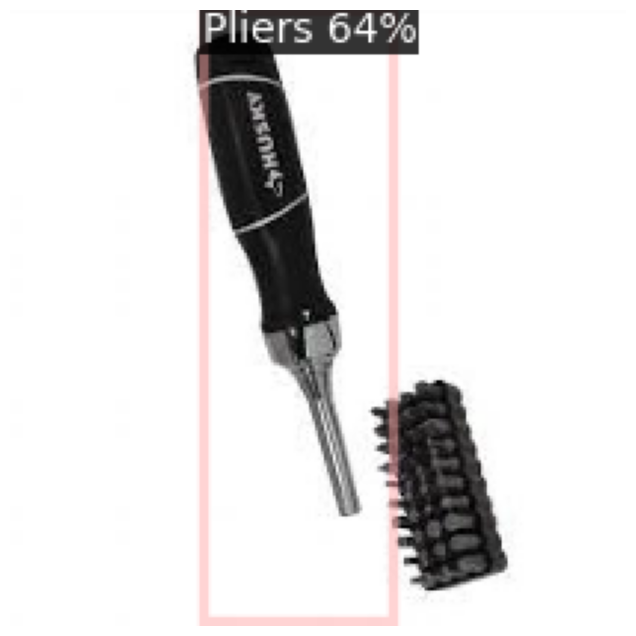

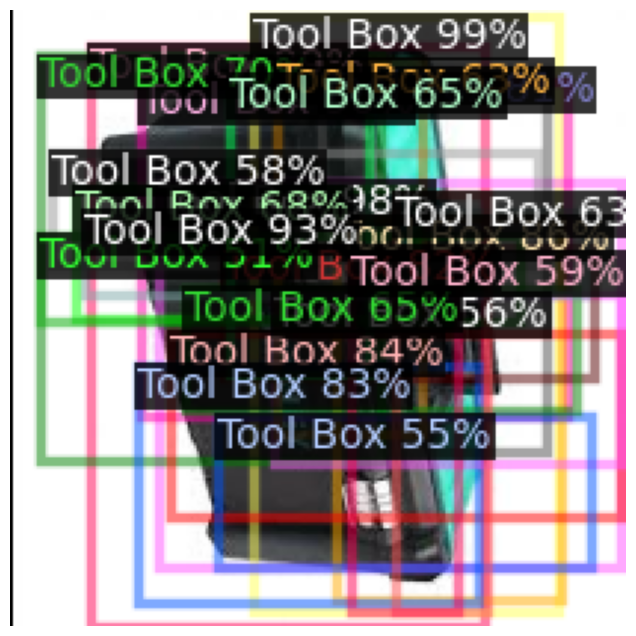

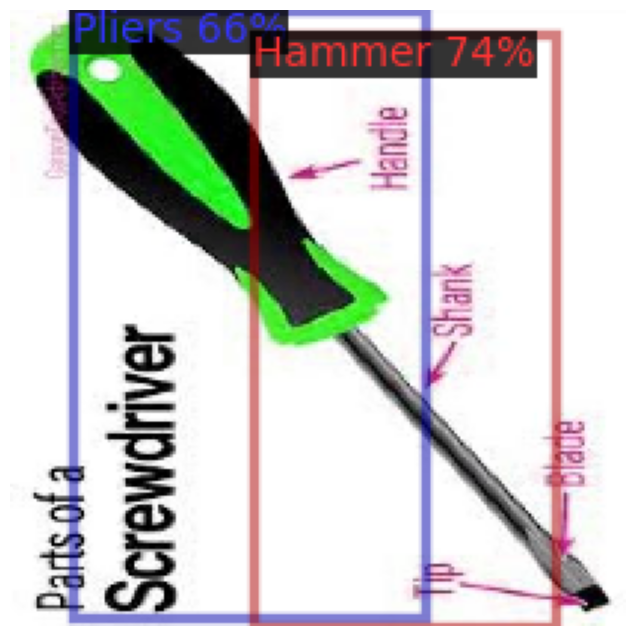

In [53]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

for i, data in enumerate(random.sample(train_dataset_dicts, 5)):
    img = cv2.imread(data["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(12, 8))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


## More Results

WARNING [09/29 19:46:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/29 19:46:55 d2.data.datasets.coco]: Loaded 26 images in COCO format from /content/drive/MyDrive/HW4-detectron2/test/_annotations.coco.json


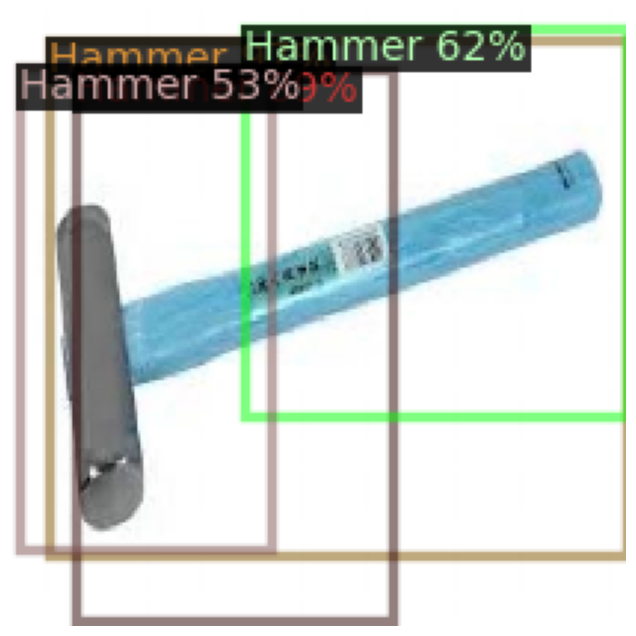

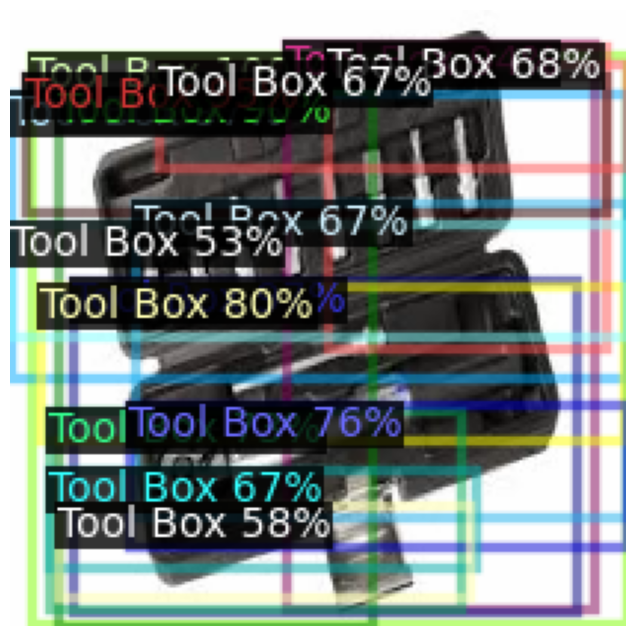

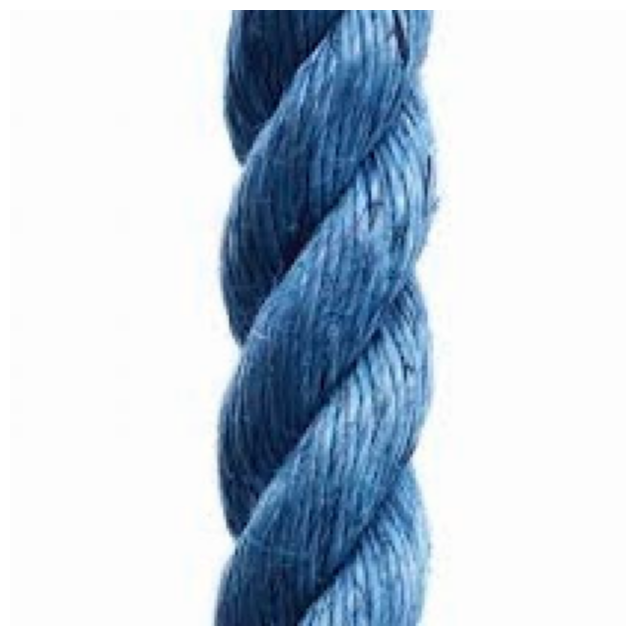

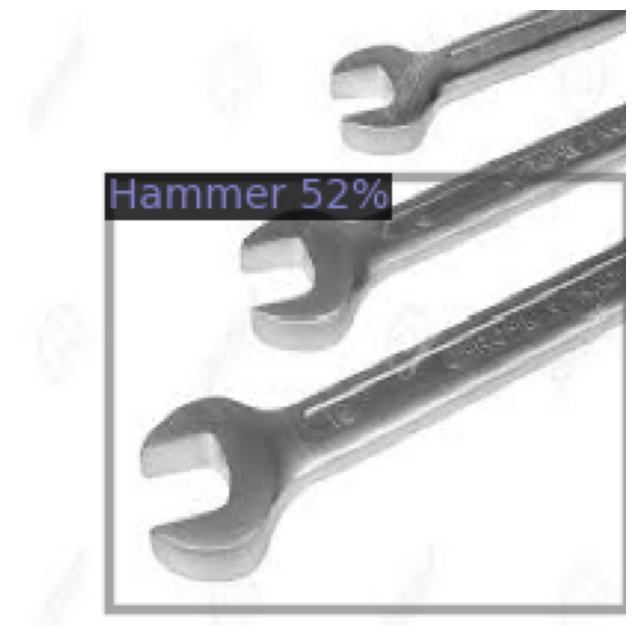

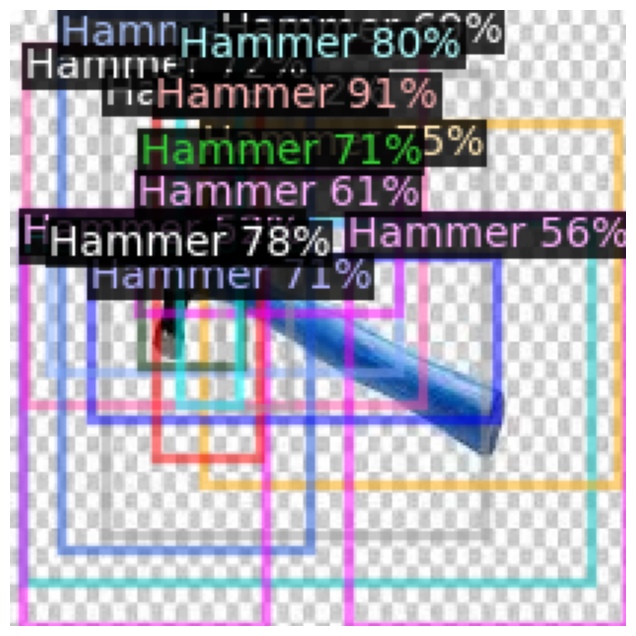

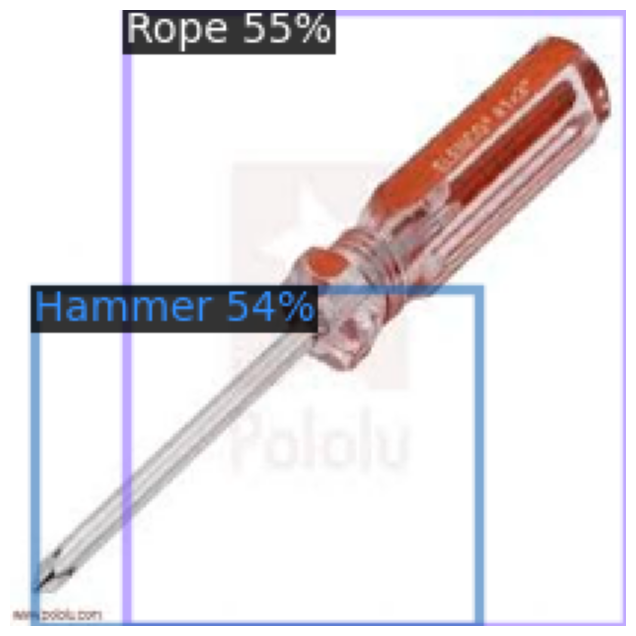

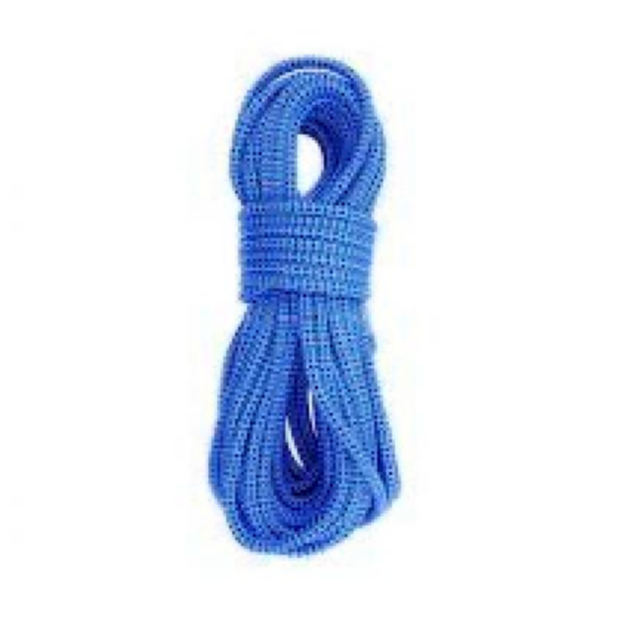

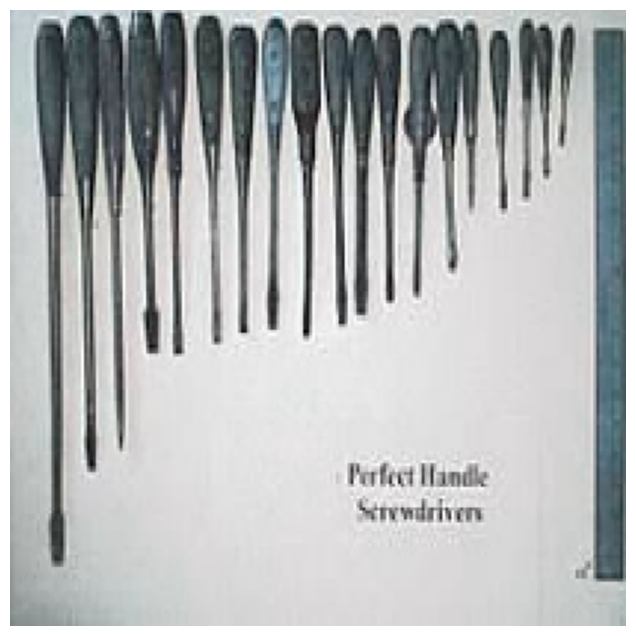

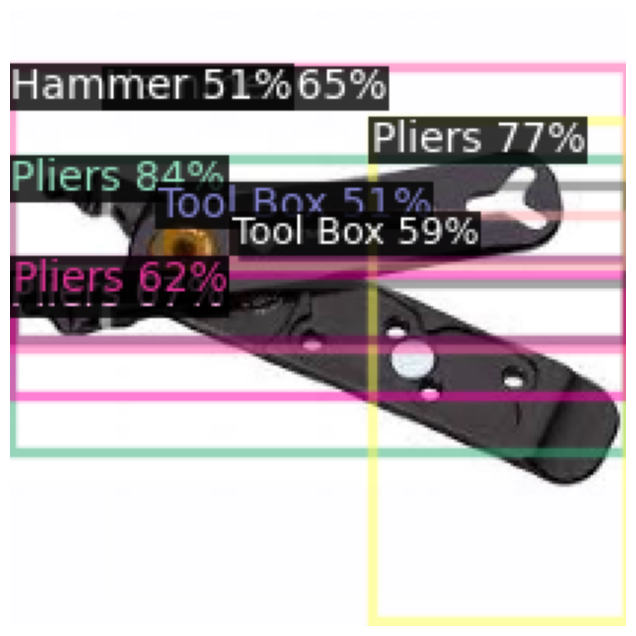

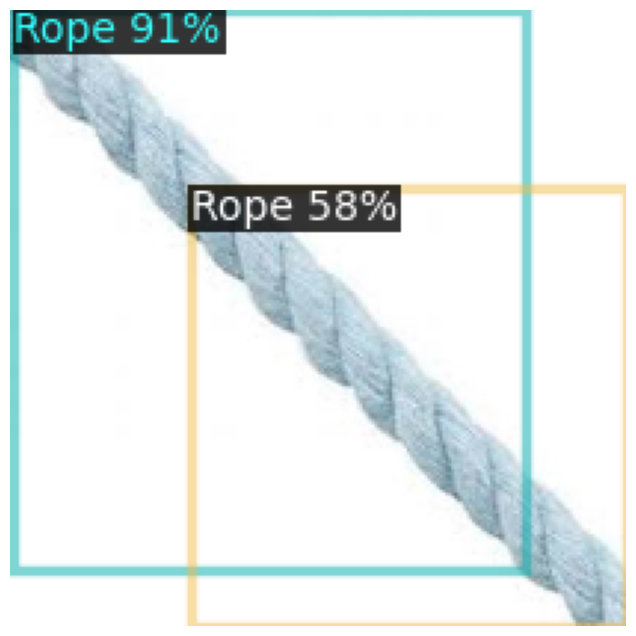

In [56]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

# Parameters
num_samples = 10  # Number of images to visualize; increase this to visualize more
output_dir = "/content/drive/MyDrive/detectron2_output"
os.makedirs(output_dir, exist_ok=True)

# Retrieve the dataset to visualize (e.g., test dataset)
test_dataset_dicts = DatasetCatalog.get("my_test_dataset")  # Change to "my_val_dataset" or "my_train_dataset" as needed

# Visualize predictions on the specified number of images
for i, data in enumerate(random.sample(test_dataset_dicts, num_samples)):
    img = cv2.imread(data["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Save the visualized image to the output directory
    output_path = os.path.join(output_dir, f"prediction_{i}.png")
    cv2.imwrite(output_path, v.get_image()[:, :, ::-1])

    # Display the image in the notebook
    plt.figure(figsize=(12, 8))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()
